In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

path_df = "..\\data\\"

In [2]:
data = pd.read_csv(path_df+'DS_Bitácora_41_Temperatura.csv')
data['fecha'] = pd.to_datetime({'year':data.anio, 'month': data.mes, 'day': data.dia})
data.head()

,dia,mes,anio,Tmax,Tmin,fecha
0,1,1,1959,25.6,11.6,1959-01-01
1,2,1,1959,26.2,16.4,1959-01-02
2,3,1,1959,27.3,18.8,1959-01-03
3,4,1,1959,25.4,16.6,1959-01-04
4,5,1,1959,21.6,10.7,1959-01-05


### Clase pasada
### Remplazado por valroes nulos >50 la temperatura tanto en el limite minimo como maximo
### sacamos dia, mes, anio

In [3]:
semanal = data.resample('W', on = 'fecha').mean()
semanal.Tmax[semanal.Tmax > 50] = np.nan
semanal.Tmin[semanal.Tmin > 50] = np.nan
semanal.drop(columns = ['dia', 'mes', 'anio'], inplace = True)

### Tmean, media de temperatura

### (semanal.Tmax + semanal.Tmin)/2

In [4]:
semanal['Tmean'] = (semanal.Tmax + semanal.Tmin)/2
semanal = semanal.interpolate()
semanal.head()

,Tmax,Tmin,Tmean
fecha,,,
1959-01-04,26.125000,15.850000,20.987500
1959-01-11,26.600000,12.785714,19.692857
1959-01-18,28.300000,16.885714,22.592857
1959-01-25,31.300000,16.400000,23.850000
1959-02-01,27.633333,16.014286,21.823810


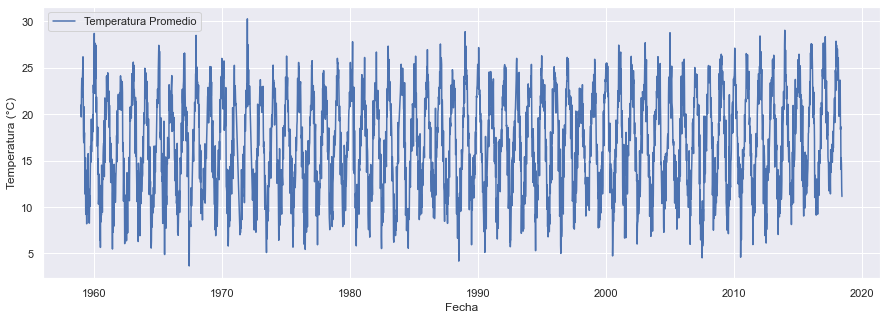

In [5]:
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.Tmean, label = 'Temperatura Promedio')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
# plt.xlim(datetime.date(1990,1,1), datetime.date(2018,1,1))
# plt.ylim(-10,40)
plt.legend()
plt.show()

### Hacemos un lags de 1000 semanas dado que 60 años son 3000mil semanas

In [6]:
from statsmodels.tsa.stattools import acf

nlags =  52*20
autocorr = acf(semanal.Tmean, nlags = nlags)

C:\ProgramData\Anaconda3\envs\acamica\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 0, 'lag')

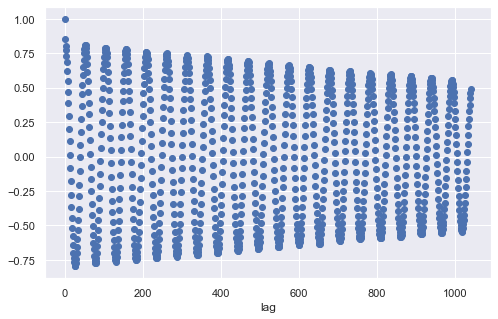

In [7]:
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

A este gráfico a veces se lo suele llamar correlograma.

Para pensar e investigar: ¿por qué el primer valor es 1?¿Por qué va decreciendo en el tiempo?¿Qué nos puede decir eso con respecto al problema de predicción a futuro?

Los valores más alejados en el tiempo son aquellos más dificiles de predecir. Que el primer número sea uno significa que la serie empezó totalmente correlacionada y fue perdiendo esa autocorrelación


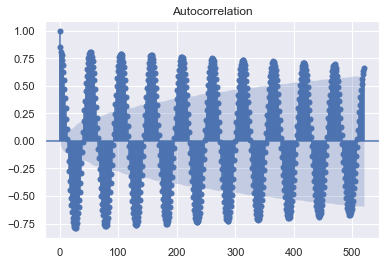

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(semanal.Tmean, lags = 52*10)
plt.show()

# Prediccion

In [9]:
senial = semanal.Tmean
senial.head()

fecha
1959-01-04    20.987500
1959-01-11    19.692857
1959-01-18    22.592857
1959-01-25    23.850000
1959-02-01    21.823810
Freq: W-SUN, Name: Tmean, dtype: float64

¿Cuantos valores hacia atrás tomamos?

### 52*2 dos años?

In [10]:
look_back = 52*2 # usamos dos anios de datos para predecir el valor siguiente

In [11]:
N = len(senial)

In [12]:
X = np.zeros((N - look_back - 1,look_back))


In [13]:
y = np.zeros(N - look_back - 1)


In [14]:
print(X.shape, y.shape)

(2998, 104) (2998,)


In [15]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [16]:
N_train = 10*52 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 4*52 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

In [17]:
X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

(416, 104) (416,)


In [18]:
X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(208, 104) (208,)


### Predecimos

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [20]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

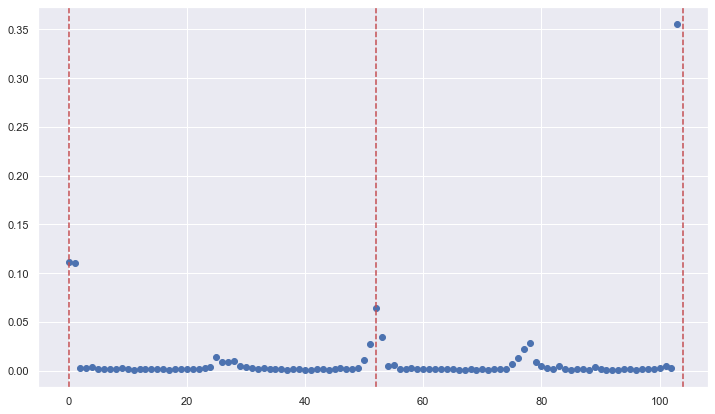

In [21]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(3)*52:
    plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [22]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

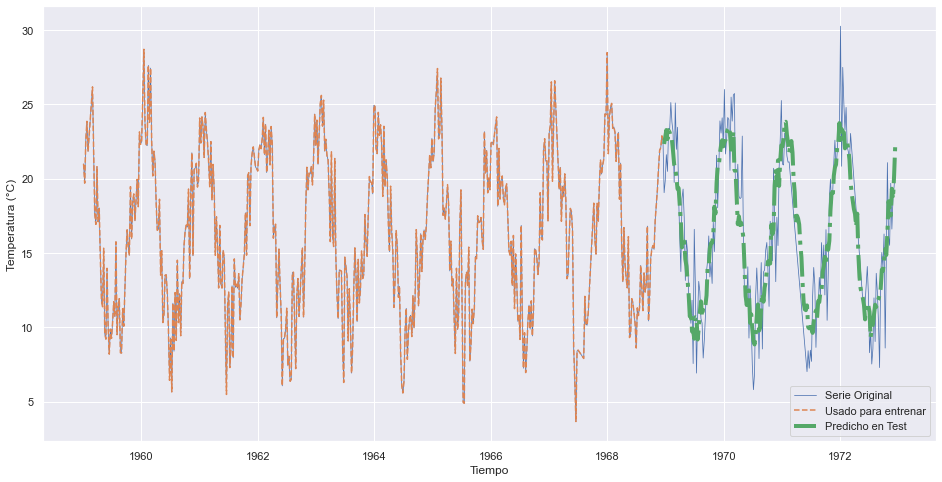

In [23]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.show()

In [24]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 0.9169597103369038
Error en Test: 2.4564625775395004


**Benchmark**: comparamos el error con el que habríamos obtenido si predecíamos copiando el valor de la fecha anterior.

In [25]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

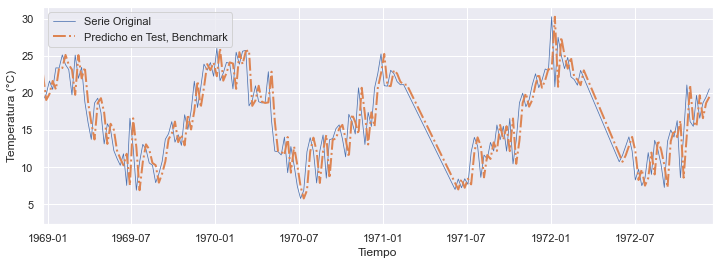

In [26]:
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

In [27]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

2.9813397301215194


### 2.2. Multi-Step Prediction

Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.

In [28]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

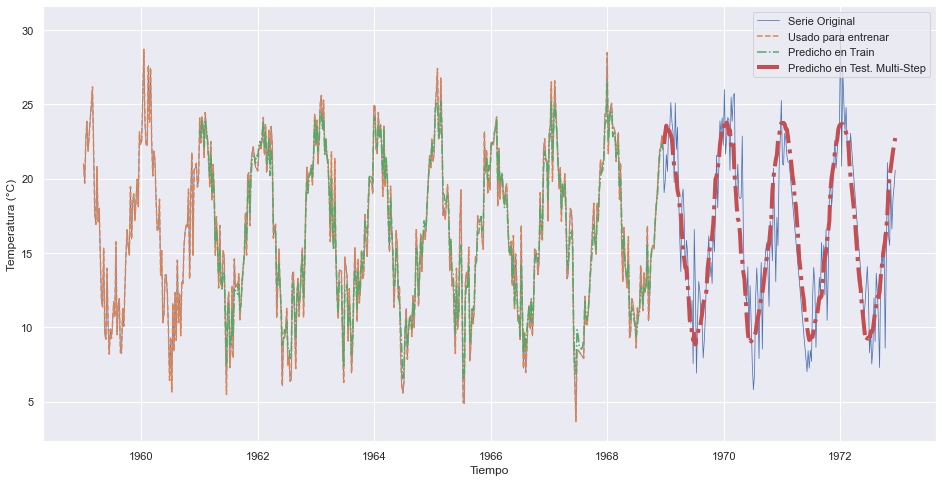

In [29]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.show()

In [30]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Train:',np.sqrt(MSE))

Error en Train: 2.583130551762868


### Prophet

In [31]:
from fbprophet import Prophet

In [56]:
data = pd.read_csv(path_df+'DS_Bitácora_41_Temperatura.csv')
data['fecha'] = pd.to_datetime({'year':data.anio, 'month': data.mes, 'day': data.dia})
data.head()

,dia,mes,anio,Tmax,Tmin,fecha
0,1,1,1959,25.6,11.6,1959-01-01
1,2,1,1959,26.2,16.4,1959-01-02
2,3,1,1959,27.3,18.8,1959-01-03
3,4,1,1959,25.4,16.6,1959-01-04
4,5,1,1959,21.6,10.7,1959-01-05


In [57]:
semanal = data.resample('W', on = 'fecha').mean()
semanal.Tmax[semanal.Tmax > 50] = np.nan
semanal.Tmin[semanal.Tmin > 50] = np.nan
semanal.drop(columns = ['dia', 'mes', 'anio'], inplace = True)

semanal['Tmean'] = (semanal.Tmax + semanal.Tmin)/2
semanal = semanal.interpolate()
semanal.head()

,Tmax,Tmin,Tmean
fecha,,,
1959-01-04,26.125000,15.850000,20.987500
1959-01-11,26.600000,12.785714,19.692857
1959-01-18,28.300000,16.885714,22.592857
1959-01-25,31.300000,16.400000,23.850000
1959-02-01,27.633333,16.014286,21.823810


In [58]:
semanal.reset_index(inplace=True)

In [61]:
semanal['year'] = semanal['fecha'].map(lambda x: x.year)
semanal['month'] = semanal['fecha'].map(lambda x: x.month)

In [62]:
semanal

,fecha,Tmax,Tmin,Tmean,year,month
0,1959-01-04,26.125000,15.850000,20.987500,1959,1
1,1959-01-11,26.600000,12.785714,19.692857,1959,1
2,1959-01-18,28.300000,16.885714,22.592857,1959,1
3,1959-01-25,31.300000,16.400000,23.850000,1959,1
4,1959-02-01,27.633333,16.014286,21.823810,1959,2
...,...,...,...,...,...,...
3098,2018-05-20,17.857143,10.242857,14.050000,2018,5
3099,2018-05-27,20.500000,10.085714,15.292857,2018,5
3100,2018-06-03,18.071429,11.014286,14.542857,2018,6
3101,2018-06-10,15.614286,8.257143,11.935714,2018,6


In [ ]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

In [63]:
min_year = semanal['year'].min()
max_year = semanal['year'].max()
length = max_year - min_year + 1
years = [min_year]
for i in range(1,length):
    years.append(min_year + i) 

In [1]:
#avg_temp = semanal['y'].groupby(semanal['year']).mean()


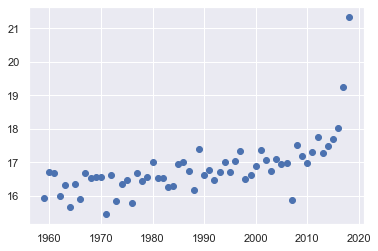

In [65]:
plt.scatter(years, avg_temp)


In [53]:
avg_df = pd.DataFrame()
avg_df['y']=avg_temp
avg_df['Year']=years
avg_df['ds']=pd.to_datetime(avg_df['Year'], format='%Y')
length

60

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


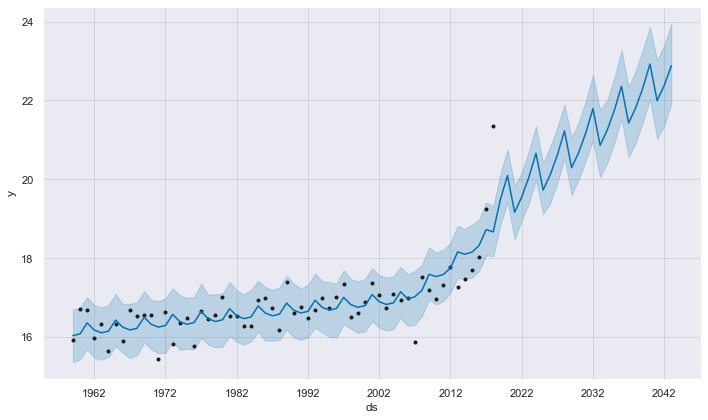

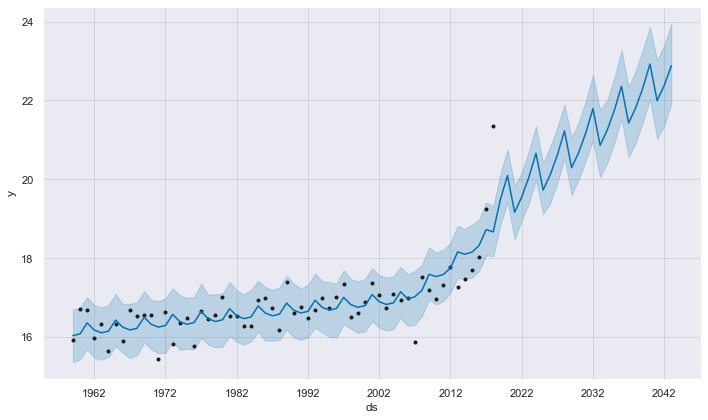

In [54]:
m = Prophet(n_changepoints=1)
m.fit(avg_df)
future = m.make_future_dataframe(periods=25, freq = 'Y')
forecast = m.predict(future)
m.plot(forecast)

In [55]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,1959-01-01,16.033736,15.355022,16.696661
1,1960-01-01,16.075580,15.429015,16.739206
2,1961-01-01,16.356324,15.693827,17.011450
3,1962-01-01,16.175315,15.471660,16.807268
4,1963-01-01,16.105585,15.422044,16.747634
...,...,...,...,...
80,2038-12-31,22.315501,21.457224,23.283208
81,2039-12-31,22.926115,22.033636,23.864767
82,2040-12-31,21.993431,21.023667,23.020343
83,2041-12-31,22.382059,21.353422,23.404504
